# Tutorial to use training_model

## install

In [ ]:
!conda install numpy pandas matplotlib tensorflow-gpu tensorflow-addons

In [ ]:
!pip install quippy-ase scikit-learn tqdm

## pre-define

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nmr import NMRModel, get_df_from_outcar, get_df_from_outcars, sample_from_df, filter_total_energy_change

In [3]:
plt.rcParams['figure.figsize'] = (3, 2)
plt.rcParams['figure.dpi'] = 200

In [4]:
# 直接可定义的，不同体系需定义的值不同
expression = "soap cutoff=5.5 cutoff_transition_width=0.5 n_max=9 l_max=9 atom_sigma=0.55 n_Z=1 n_species=4 species_Z={11, 12, 25, 8}"
elements = ['Na']
n_Na = 16 # n_Na = len(np.where(cs == 'Na'))
# n_split = 5

In [6]:
# only occupy 1 GPU, if not set, it will meaningless occupy a bit memory of other GPUs
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## get data from OUTCAR

- input: 
    - OUTCAR
    - expression
    - elements


- output: 
    - DataFrame(X: soaps, y: FCShifts)

In [7]:
df = get_df_from_outcar('OUTCAR2', expression=expression, elements=elements)
df

,X,y
0,"[0.06961377296608312, 2.1820516647534952e-08, ...",1731.556754
1,"[0.058966622699910896, 1.3131280116785133e-07,...",2451.705127
2,"[0.06418028321861413, 2.4773533524402472e-08, ...",1587.527080
3,"[0.06035417497947536, 1.2368738576021173e-07, ...",1877.986923
4,"[0.06788864905088919, 3.056988017422738e-08, 1...",2140.440997
5,"[0.06802443229991319, 1.72129832568093e-08, 1....",584.920512
6,"[0.07121729109996425, 1.1494748235241847e-08, ...",1025.811349
7,"[0.060434673111582855, 3.2885387839523326e-08,...",1758.762359
8,"[0.06150853467631573, 1.066736521228745e-08, 1...",1435.495756
9,"[0.05947944218344097, 2.351091372984001e-08, 2...",2136.440173


In [8]:
df = get_df_from_outcar('OUTCAR2', expression=expression, elements=elements, 
                        gamma=100, mu_eff=3.87, cell_S=48, s=1.5, T=320, sigma=-14.8)

In [9]:
# get data from many OUTCARs & select convergent OUTCARs
outcar_filenames = ['OUTCAR2', 'OUTCAR4']
df_all = get_df_from_outcars(outcar_filenames, expression=expression, elements=elements, outcar_filter=filter_total_energy_change)

In [ ]:
# store data
df_all.to_pickle('xxx.pkl', protocol=4)

## Training

- input: 
    - foldername
    - data(DataFrame)
    - n_samples
    - vector_dim


- output files stored in foldername(input): 
    - data(sampling from input data)
    - i.dat(load by joblib, split from "output data")(train_X, test_X, train_y, test_y)
    - models(model_i corresponds to i.dat)
    - rmse_scores(corresponds to i.dat)


### kfolder

In [7]:
data_1000 = pd.read_pickle('na_data_1000.pkl') # read all data
foldername = 'na_data_200'
data = sample_from_df(data_1000, 200*n_Na, f'{foldername}/na_data_200.pkl') # sample 200*16 data
X, y = NMRModel.get_Xy_from_df(data) # get X and y data from sampled data
NMRModel(X, y).train_kfolder_models(foldername=foldername)

### non-kfolder

2021-11-15 20:02:37.837073: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-15 20:02:37.838740: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-15 20:02:37.955150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:b2:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-15 20:02:37.955249: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-15 20:02:37.958577: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-15 20:02:37.958707: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

2021-11-15 20:02:39.809950: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-15 20:02:39.810601: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2021-11-15 20:02:40.454355: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-15 20:03:49.058808: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: na_data_200/model_test/assets
rmse: 265.22761800820706 ppm


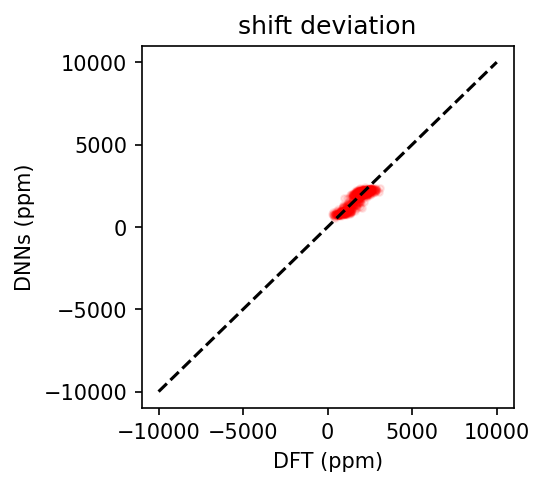

In [10]:
data_1000 = pd.read_pickle('na_data_1000.pkl') # read all data
foldername = 'na_data_200'
data = sample_from_df(data_1000, 200*n_Na, f'{foldername}/na_data_200.pkl') # sample 200*16 data
X, y = NMRModel.get_Xy_from_df(data) # get X and y data from sampled data
history, ax = NMRModel(X, y).train_model(filename=f'{foldername}/model_test')

### get rmse test_y test_y_pred

In [14]:
rmse_testdata = np.load('na_data_200/rmse_and_test_data.npy', allow_pickle=True)
print(f'rmse: {rmse_testdata.item()["rmse"]}')
print(f'test_y: {rmse_testdata.item()["test_y"]}')
print(f'test_y_pred: {rmse_testdata.item()["test_y_pred"]}')

rmse: 265.22761800820706
test_y: [1875.58642867 1187.44465023 1773.96549162 2075.62764333 2165.2461075
 1790.76895365 1868.38494494 2061.22467588 2082.0289622  1197.04662854
 2134.83984287 1009.80805161 2386.09160849 1783.56746993 2179.64907496
 1134.63376956 2166.84643722 2503.71584271 2182.84973439 1198.64695825
 1093.82536177 1937.99928765  656.93534895 1441.89707528 2327.67957381
 1680.34620316 2658.94782529 2382.89094905  776.96007775 2186.05039383
  602.52413856 2526.92062361 2622.14024179 1491.50729652 1037.81382167
 1180.24316651 2543.72408564 1848.38082348 1732.35691897 1001.00623817
 1680.34620316 2187.65072354 2092.43110536 2074.02731362 1377.08372173
 1038.61398652 2040.42038955 2497.31452384 2039.62022469 2309.27578206
  907.38694971 1868.38494494 1097.82618606 1685.94735717 2021.21643294
 2509.31699672  906.58678485  408.88424277 1237.85503633 2579.73150428
  737.75199967 1658.74175198  727.34985651 1935.59879307 1727.55592982
 1805.17192111  461.69512344 1966.80522256 17

## Predict

- input:
    - model
    - vector_dim
    - atoms
    - expression
    - elements


- output:
    - FCShifts

In [15]:
from ase.io import read
atoms = read('OUTCAR2')

In [19]:
X = NMRModel.get_X_from_df(df_all)
nmr = NMRModel(X)
nmr.load_model('na_data_200/model_test') # load model
fcshifts = nmr.predict_fcshifts(atoms, expression, elements=elements) # predict

In [20]:
# ML FCShifts
fcshifts

array([1717.4092, 2205.5286, 1862.0208, 2240.1934, 1909.9755,  794.7656,
       1161.021 , 2102.1375, 2079.5256, 2173.811 , 1937.3062, 1614.5946,
       2022.7245, 1225.0322, 2228.7222,  953.6044], dtype=float32)

In [21]:
# DFT FCShifts
df['y'].values

array([1731.55675411, 2451.7051269 , 1587.52707956, 1877.98692325,
       2140.44099688,  584.92051167, 1025.81134879, 1758.76235931,
       1435.49575641, 2136.44017259, 1869.1851098 , 1456.30004274,
       2182.04956953, 1433.8954267 , 2562.12787739,  869.77920135])

In [22]:
# calc rmse
from sklearn.metrics import mean_squared_error
mean_squared_error(fcshifts.flatten(), df['y'].values, squared=False)

266.1935178044531

## Plot figures

In [1]:
from training_model import plot_dft_validation
import matplotlib.pyplot as plt
import numpy as np
fcshifts = np.array([1717.4092, 2205.5286, 1862.0208, 2240.1934, 1909.9755,  794.7656,1161.021 , 2102.1375, 2079.5256, 2173.811 , 1937.3062, 1614.5946,2022.7245, 1225.0322, 2228.7222,  953.6044])
y = np.array([1731.55675411, 2451.7051269 , 1587.52707956, 1877.98692325,2140.44099688,  584.92051167, 1025.81134879, 1758.76235931,1435.49575641, 2136.44017259, 1869.1851098 , 1456.30004274,2182.04956953, 1433.8954267 , 2562.12787739,  869.77920135])

2021-12-27 15:49:35.396010: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


rmse: 266.1935170456326 ppm


<AxesSubplot:title={'center':'shift deviation'}, xlabel='DFT (ppm)', ylabel='DNNs (ppm)'>

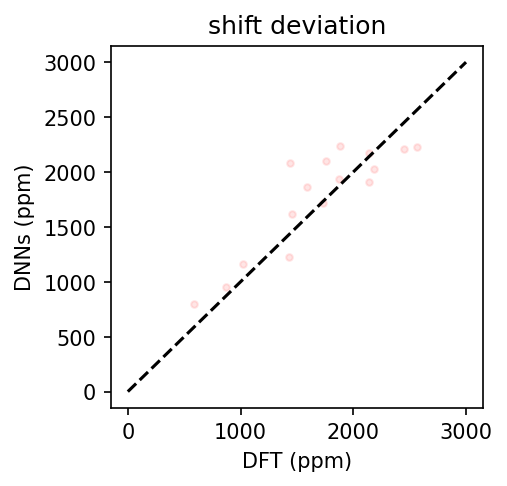

In [2]:
plot_dft_validation(y, fcshifts)